In [191]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_poisson_deviance
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split

import matplotlib.pyplot as plt

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

df = pd.read_csv('HourlyForecastTrainingSet.csv')

df["delivery_date_h_sin"] = sin_transformer(24).fit_transform(df[['delivery_date_h']])["delivery_date_h"]
df["delivery_date_h_cos"] = cos_transformer(24).fit_transform(df[['delivery_date_h']])["delivery_date_h"]
df["delivery_date_dow_sin"] = sin_transformer(7).fit_transform(df[['delivery_date_dow']])["delivery_date_dow"]
df["delivery_date_dow_cos"] = cos_transformer(7).fit_transform(df[['delivery_date_dow']])["delivery_date_dow"]

df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

lst = ['city_destination', 'old_forecast', 'observation_date', 'booked_start_at_local','delivery_date_h','delivery_date_dow','forecast_id']

ml_df = df.drop(lst, axis = 1)
ml_df = ml_df.dropna()

In [192]:
ml_df.head()

,delivery_date_weekday,lead_time,total_booked_rs,perc_booked_running_sum,avg_rolling_dh_avg4_exp_mov_avg4,avg_rolling_dh_avg4_exp_mov_avg5,avg_rolling_dh_avg4_exp_mov_avg6,avg_rolling_dh_avg2_exp_mov_avg4,avg_rolling_dh_avg2_exp_mov_avg5,avg_rolling_dh_avg2_exp_mov_avg6,...,avg_rolling_d_avg14_exp_mov_avg6,avg_rolling_d_avg7_exp_mov_avg4,avg_rolling_d_avg7_exp_mov_avg5,avg_rolling_d_avg7_exp_mov_avg6,total_cancelations_rs,target,delivery_date_h_sin,delivery_date_h_cos,delivery_date_dow_sin,delivery_date_dow_cos
0,0,20,2,0.31,5.0,7.0,9.0,7.0,10.0,12.0,...,13.0,6.0,10.0,13.0,0.0,3,-0.707107,-0.707107,-0.433884,-0.900969
1,0,16,2,0.31,5.0,7.0,9.0,7.0,10.0,12.0,...,13.0,6.0,10.0,13.0,0.0,3,-0.707107,-0.707107,-0.433884,-0.900969
2,0,5,2,0.50,4.5,7.0,9.5,4.0,5.5,8.0,...,14.5,7.0,10.5,14.5,0.0,3,-0.707107,-0.707107,-0.433884,-0.900969
3,0,1,5,1.00,4.5,7.0,9.5,4.0,5.5,8.0,...,14.5,7.0,10.5,14.5,0.0,3,-0.707107,-0.707107,-0.433884,-0.900969
4,0,24,0,0.00,2.0,4.0,7.0,3.0,5.0,8.0,...,11.0,5.0,7.0,11.0,0.0,0,-0.500000,0.866025,0.974928,-0.222521


Root Mean Squared Error: 4.842489323175327
Mean Absolute Error: 2.08278532961156
Mean Poisson Deviance Error: 2.856269989891358
R-squared: 0.7504977114766709


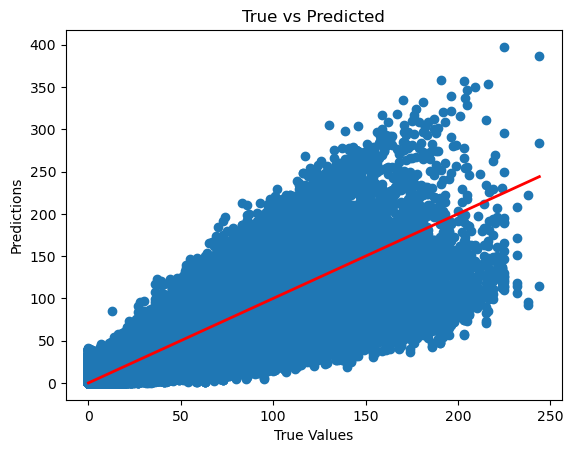

In [193]:
X = ml_df.drop(columns=['target'])
y = ml_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train_ = sc.fit_transform(X_train)
X_test_ = sc.transform(X_test)

model = LinearRegression()
model.fit(X_train_, y_train)

y_pred = abs(model.predict(X_test_))

rmse = root_mean_squared_error(y_test, y_pred)
mae =  mean_absolute_error(y_test, y_pred)
mpde = mean_poisson_deviance(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Poisson Deviance Error: {mpde}")
print(f"R-squared: {r2}")

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()

In [194]:
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Intercept': model.intercept_,
    'Coef': model.coef_
})

print(coef_df)

                             Feature  Intercept       Coef
0              delivery_date_weekday   2.658136  -0.031016
1                          lead_time   2.658136   0.478700
2                    total_booked_rs   2.658136   4.901440
3            perc_booked_running_sum   2.658136  -0.477201
4   avg_rolling_dh_avg4_exp_mov_avg4   2.658136   0.389384
5   avg_rolling_dh_avg4_exp_mov_avg5   2.658136  -2.238030
6   avg_rolling_dh_avg4_exp_mov_avg6   2.658136   1.963145
7   avg_rolling_dh_avg2_exp_mov_avg4   2.658136  -3.717615
8   avg_rolling_dh_avg2_exp_mov_avg5   2.658136  -5.524496
9   avg_rolling_dh_avg2_exp_mov_avg6   2.658136  14.937801
10  avg_rolling_d_avg14_exp_mov_avg4   2.658136   0.747852
11  avg_rolling_d_avg14_exp_mov_avg5   2.658136   0.305389
12  avg_rolling_d_avg14_exp_mov_avg6   2.658136  -2.319511
13   avg_rolling_d_avg7_exp_mov_avg4   2.658136   1.128649
14   avg_rolling_d_avg7_exp_mov_avg5   2.658136   0.688728
15   avg_rolling_d_avg7_exp_mov_avg6   2.658136  -3.2221

<Figure size 1000x600 with 0 Axes>

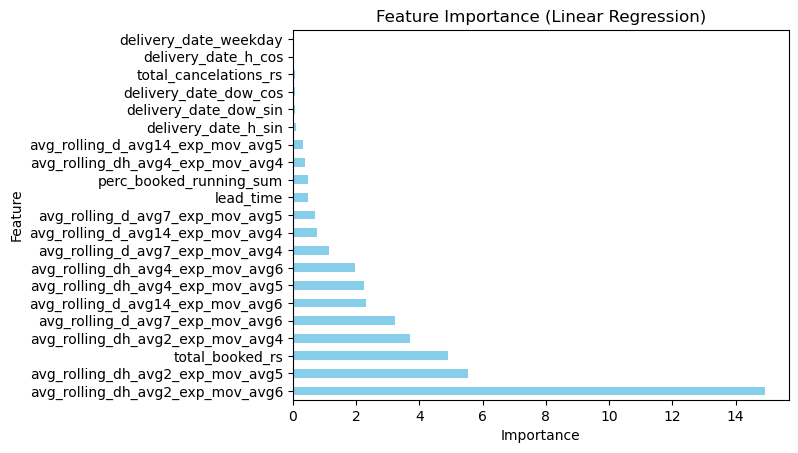

In [195]:
feature_importance = abs(model.coef_)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Feature Importance (Linear Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [196]:
cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error')

cv_scores = -cv_scores  
mean_cv_score = np.mean(cv_scores)

print(f"Cross-validated Mean Squared Error (MSE): {mean_cv_score:.4f}")
print(f"Individual Fold Scores (MSE): {cv_scores}")

Cross-validated Mean Squared Error (MSE): 4.8966
Individual Fold Scores (MSE): [4.07502124 4.70204331 5.10653701 5.05953706 5.12813908 4.88441722
 4.89842265 4.95092675 5.28031322 4.88017577]


In [197]:
model = LinearRegression()

coefficients = []

rmse_scores = []
mae_scores = []

tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    coefficients.append(model.coef_)
    
    y_pred = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores.append(rmse)
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

coefficients_df = pd.DataFrame(coefficients, columns=X.columns)

average_rmse = np.mean(rmse_scores)
average_mae = np.mean(mae_scores)

print(f"Average RMSE across all folds: {average_rmse:.4f}")
print(f"Average MAE across all folds: {average_mae:.4f}")

print("Coefficients for each fold:")
print(coefficients_df)

Average RMSE across all folds: 4.9925
Average MAE across all folds: 2.1845
Coefficients for each fold:
   delivery_date_weekday  lead_time  total_booked_rs  perc_booked_running_sum  \
0              -0.022406   0.050275         1.050743                -1.560502   
1              -0.038875   0.051932         1.034377                -1.574644   
2              -0.044737   0.054080         1.003564                -1.612537   
3              -0.054661   0.054601         0.987587                -1.619842   
4              -0.053542   0.055877         0.978394                -1.632715   
5              -0.058120   0.056275         0.976166                -1.633372   
6              -0.061134   0.056397         0.971538                -1.630717   
7              -0.063170   0.056441         0.970231                -1.627423   
8              -0.064118   0.056573         0.968637                -1.626902   
9              -0.067911   0.057263         0.967805                -1.636410   

   av

Root Mean Squared Error: 3.6924168184061146
Mean Absolute Error: 1.4927248174391239
Mean Poisson Deviance Error: 2.0740141633172473
R-squared: 0.8549363399911272


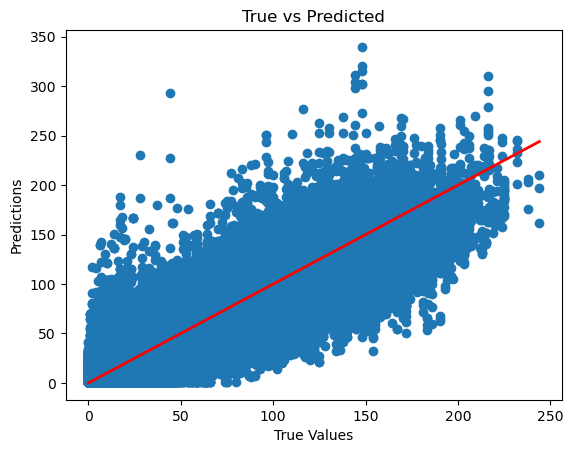

In [198]:
#Comparison with the Linear Regression trained on total_booked_cancellation_prediction

ml_df2 = df.copy()

X_actual = ml_df2[['old_forecast']]
y_actual = ml_df2['target']

X_train_actual, X_test_actual, y_train_actual, y_test_actual = train_test_split(X_actual, y_actual, test_size=0.2, random_state=42)


sc_act = StandardScaler()
X_train_actual_ = sc.fit_transform(X_train_actual)
X_test_actual_ = sc.transform(X_test_actual)


model_actual = LinearRegression()
model_actual.fit(X_train_actual, y_train_actual)

y_pred_actual = abs(model_actual.predict(X_test_actual))

rmse_actual = root_mean_squared_error(y_test_actual, y_pred_actual)
mae_actual =  mean_absolute_error(y_test_actual, y_pred_actual)
mpde_actual = mean_poisson_deviance(y_test_actual, y_pred_actual)
r2_actual = r2_score(y_test_actual, y_pred_actual)

print(f"Root Mean Squared Error: {rmse_actual}")
print(f"Mean Absolute Error: {mae_actual}")
print(f"Mean Poisson Deviance Error: {mpde_actual}")
print(f"R-squared: {r2_actual}")

plt.scatter(y_test_actual, y_pred_actual)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()

Root Mean Squared Error: 3.9125905314603155
Mean Absolute Error: 1.3692808853509753
R-squared: 0.837120664463433


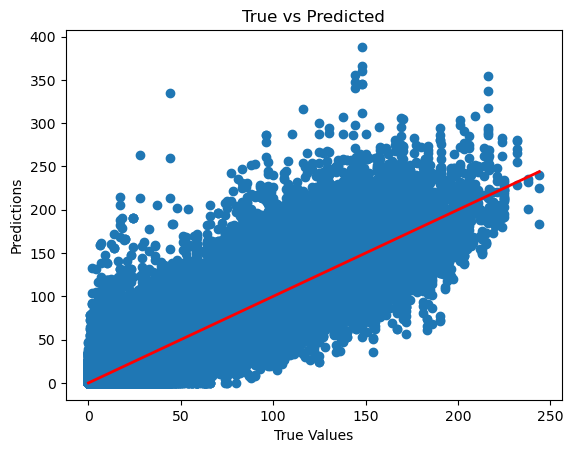

In [199]:
#Comparison between total_booked_cancellation_prediction and target_demanded

rmse_actual_ = root_mean_squared_error(y_test_actual, X_test_actual)
mae_actual_ =  mean_absolute_error(y_test_actual, X_test_actual)
r2_actual_ = r2_score(y_test_actual, X_test_actual)

print(f"Root Mean Squared Error: {rmse_actual_}")
print(f"Mean Absolute Error: {mae_actual_}")
print(f"R-squared: {r2_actual_}")

plt.scatter(y_test_actual, X_test_actual)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()